### Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import dateutil
from datetime import timedelta
from collections import Counter
pd.set_option('display.max_columns', 500)
import ast
import re
from tqdm.notebook import tqdm, tnrange
tqdm.pandas()
import missingno as msno
import seaborn as sns
import swifter

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
import nltk.data
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
import torch
import json 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianphelps/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
'''
  GRAB MOVIE DATA FROM THREADS
'''
def createDate(row):
  if type(row)==str:
    return dateutil.parser.parse(row).strftime('%Y-%m-%d')
  else:
    return np.nan

def createDf():
  path = "./data//full_"
  paths = ['one', 'two', 'three', 'four', 'five', 'six']
  df = pd.DataFrame()
  for val in paths:
    df = df.append(pd.read_csv(f"{path}{val}.csv"))
  return df

df = createDf()

#DROP INVALID DISTRIBUTOR COLUMNS
df = df.drop(columns=['distributor'])

#DROP MOVIES WITHOUT DEPENDENT VARIABLE DATA
# df.dropna(subset=['box_office'], inplace=True)

#DROP DUPLICATE MOVIES
df = df.drop_duplicates(subset=['profile'])
df = df.reset_index(drop=True)

/Users/brianphelps/opt/anaconda3/envs/recommender/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
df.shape

(367802, 42)

In [6]:
drop_columns=['cast_members','cast_anchors','directors','release','mpaa','stars','languages','prod_anchors','budget','box_office', 'int_office', 'runtime','director_credits','cinematographer','cin_anch','musician','musician_anchor', 'prod_designer', 'prod_designer_anchor','costume_designer','costume_designer_anchor','sequel','screen_writers','screen_anchors','screen_credits','spec_eff','sound_mix','producers','prod_credits','cast_count','comp_count','version_count','references_count']
df=df.drop(columns=drop_columns)

In [7]:
df.head()

,name,profile,plot,summary,sequels,pro_comp,director_anchors,genre,star_anchs
0,Star Wars: Episode VII - The Force Awakens,/title/tt2488496/,"Luke Skywalker has vanished. In his absence, t...","Three decades after the Empire's defeat, a new...","['Star Wars: Episode IV - A New Hope', 'Star W...","['Lucasfilm', 'Bad Robot', 'Truenorth Producti...",['/name/nm0009190/'],"['Action', 'Adventure', 'Sci-Fi']","['/name/nm5397459/', '/name/nm3915784/', '/nam..."
1,Avengers: Endgame,/title/tt4154796/,"In the opening, Clint Barton is teaching his d...",After the devastating events of Avengers: Infi...,"['The Avengers', 'Avengers: Age of Ultron', 'A...",['Marvel Studios'],"['/name/nm0751577/', '/name/nm0751648/']","['Action', 'Adventure', 'Drama']","['/name/nm0000375/', '/name/nm0262635/', '/nam..."
2,Avatar,/title/tt0499549/,The story opens with a sweeping shot high acro...,A paraplegic Marine dispatched to the moon Pan...,NaN,"['Twentieth Century Fox', 'Dune Entertainment'...",['/name/nm0000116/'],"['Action', 'Adventure', 'Fantasy']","['/name/nm0941777/', '/name/nm0757855/', '/nam..."
3,Black Panther,/title/tt1825683/,A voice from a young boy asks to tell him a st...,"T'Challa, heir to the hidden but advanced king...",NaN,"['Marvel Studios', 'Walt Disney Pictures']",['/name/nm3363032/'],"['Action', 'Adventure', 'Sci-Fi']","['/name/nm1569276/', '/name/nm0430107/', '/nam..."
4,Avengers: Infinity War,/title/tt4154756/,SPOILER: Thanos and his Children - Proxima Mid...,The Avengers and their allies must be willing ...,"['The Avengers', 'Avengers: Age of Ultron']","['Marvel Studios', 'Jason Roberts Productions'...","['/name/nm0751577/', '/name/nm0751648/']","['Action', 'Adventure', 'Sci-Fi']","['/name/nm0000375/', '/name/nm1165110/', '/nam..."


In [8]:
errors = ['The plot is unknown at this time.','Add a Plot\xa0»','Plot unknown.','Plot kept under wraps.','Plot is unknown.','The plot is unknown.','Plot is unknown at this time.','The plot is currently unknown.','Plot is being kept under wraps.']
replace = ['See full summary\xa0»','...\n','\n']

In [9]:
df=df.reset_index(drop=True)
error_count=0
keep_indices=[]
for idx,row in tqdm(enumerate(df.itertuples()),total=len(df)):
  if row.summary in errors:
    error_count+=1
  else:
    keep_indices.append(idx)
  if type(row.summary)==str:
    for val in replace:
      if val in row.summary:
        df.at[idx, 'summary']=row.summary.replace(val, "")
    

  0%|          | 0/367802 [00:00<?, ?it/s]

In [10]:
df=df.iloc[keep_indices]

In [11]:
df=df.reset_index(drop=True)

In [12]:
def mainProd(row):
  try:
    return row[0]
  except:
    return np.nan
tqdm.pandas(desc="Production Company")
df['main_prod'] = df['pro_comp'].progress_apply(lambda x: ast.literal_eval(x)[0] if type(x)==str else np.nan)
df=df.drop('pro_comp',axis=1)

Production Company:   0%|          | 0/220819 [00:00<?, ?it/s]

In [13]:
lists = ['sequels','director_anchors','star_anchs']
for val in lists:
  df[val]=df[val].apply(lambda x: ast.literal_eval(x) if type(x)==str else np.nan)

In [14]:
fixed_plots = []
for idx, row in enumerate(df.itertuples()):
  if type(row.summary)!=str:
    if type(row.plot)==str:
      df.at[idx, 'summary']=row.plot
      fixed_plots.append(row.plot)

In [15]:
print(f"Fixed {len(fixed_plots)} movie summaries")

Fixed 185 movie summaries


In [16]:
df=df.dropna(subset=['summary'])
df=df.reset_index(drop=True)

<AxesSubplot:>

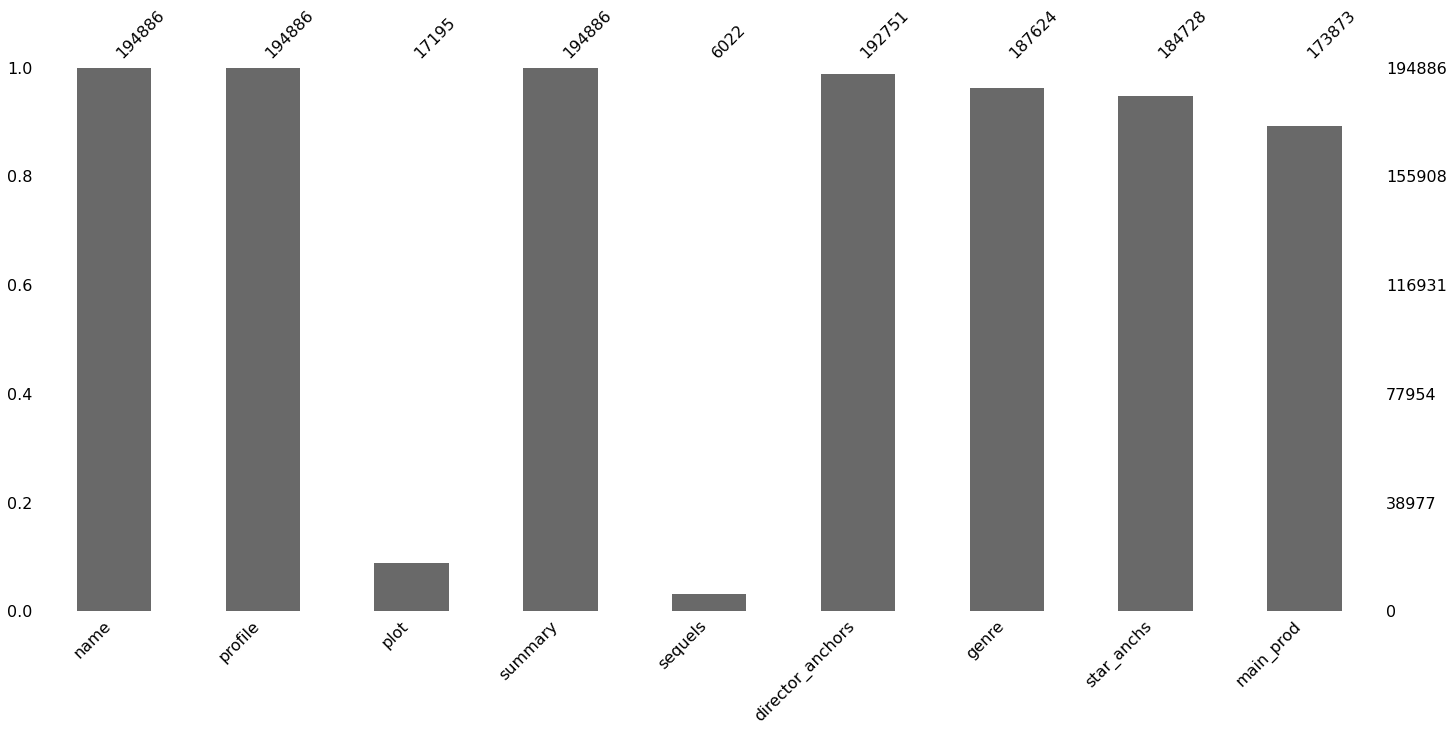

In [17]:
msno.bar(df)

### Feature Engineering

#### Genre and Director
#### Genre and Stars
#### Stars and Director
#### Stars Director Genre

In [18]:
def summary_len(text):
  result = len(tokenizer.tokenize(text))
  return result
df['summary_len']=df['summary'].apply(summary_len)

In [19]:
df['summary_len']

0         2
1         2
2         1
3         1
4         1
         ..
194881    1
194882    1
194883    1
194884    2
194885    1
Name: summary_len, Length: 194886, dtype: int64

<AxesSubplot:xlabel='summary_len'>

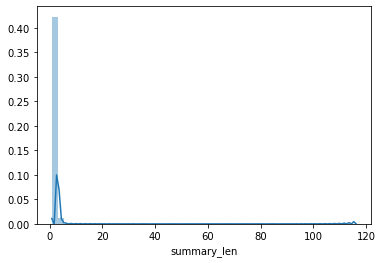

In [20]:
sns.distplot(df['summary_len'])

In [21]:
df['word_count']=df['summary'].apply(lambda x: len(x.split(" ")))

In [22]:
len(df.loc[df['word_count']<25])

59781

<AxesSubplot:xlabel='word_count'>

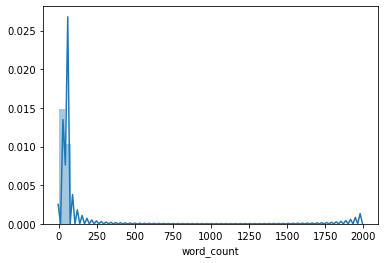

In [23]:
sns.distplot(df['word_count'])

In [24]:
np.bincount(df['summary_len'])

array([    0, 94308, 70221, 24774,  4391,   804,   175,    68,    33,
          14,     5,     8,    10,     8,     6,     3,     5,     1,
           4,     4,     3,     2,     3,     3,     1,     3,     1,
           3,     2,     0,     1,     2,     3,     0,     1,     2,
           0,     1,     0,     1,     0,     0,     1,     1,     2,
           0,     0,     2,     1,     0,     0,     0,     0,     0,
           0,     0,     0,     1,     0,     0,     0,     1,     0,
           0,     1,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     1,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     1])

In [25]:
device = torch.device('cpu')
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

Some weights of the model checkpoint at t5-small were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
def summarize_text(text):
  preprocess_text = text.strip().replace("\n","")
  t5_prepared_Text = "summarize: "+preprocess_text

  tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt")


  # summmarize 
  summary_ids = model.generate(tokenized_text,
                                      num_beams=4,
                                      no_repeat_ngram_size=2,
                                      max_length=30,
                                      early_stopping=True)

  output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
  return output

In [ ]:
df['summary_input'] = df['summary'].progress_apply(summarize_text)

Production Company:   0%|          | 0/194886 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (816 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# df['summary_input'] = df['summary'].parallel_apply(summarize_text)

In [ ]:
df.to_csv("data.csv")

In [ ]:
count = CountVectorizer()
count_matrix = count.fit_transform(df['bag_of_words'])

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)